In [1]:
# https://github.com/openai/gym/blob/5cb12296274020db9bb6378ce54276b31e7002da/gym/envs/__init__.py#L352

In [2]:
import gym
from gym import wrappers
import numpy as np
import matplotlib.pyplot as plt
import operator

from skimage.color import rgb2gray
from skimage.transform import rescale
from skimage import io

from keras import models, layers

/home/luis/anaconda3/envs/tf-source-keras-gym/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# fix neg reward to -1 , 0, or 1 orignal range is (-inf, inf)
def transform_reward(reward):
    return np.sign(reward)

In [4]:
# Q(s, a) = r + γ maxₐ’(Q(s’, a’))

In [5]:
def fit_batch(model, gamma, start_states, actions, rewards, next_states, is_terminal):
    """Do one deep Q learning iteration.
    
    Params:
    - model: The DQN
    - gamma: Discount factor (should be 0.99)
    - start_states: numpy array of starting states
    - actions: numpy array of one-hot encoded actions corresponding to the start states
    - rewards: numpy array of rewards corresponding to the start states and actions
    - next_states: numpy array of the resulting states corresponding to the start states and actions
    - is_terminal: numpy boolean array of whether the resulting state is terminal
    
    """
    # First, predict the Q values of the next states. Note how we are passing ones as the mask.
    next_Q_values = model.predict([next_states, np.ones(actions.shape)])
    # The Q values of the terminal states is 0 by definition, so override them
    next_Q_values[is_terminal] = 0
    # The Q values of each start state is the reward + gamma * the max next state Q value
    Q_values = rewards + gamma * np.max(next_Q_values, axis=1)
    # Fit the keras model. Note how we are passing the actions as the mask and multiplying
    # the targets by the actions.
    model.fit(
        [start_states, actions], actions * Q_values[:, None],
        nb_epoch=1, batch_size=len(start_states), verbose=0
)

In [6]:
def atari_model(n_actions):

    ATARI_SHAPE = (105, 80, 4)

    # With the functional API we need to define the inputs.
    frames_input = keras.layers.Input(ATARI_SHAPE, name='frames')
    actions_input = keras.layers.Input((n_actions,), name='mask')
    
    # "The first hidden layer convolves 16 8×8 filters with stride 4 with the input image and applies a rectifier nonlinearity."
    conv_1 = keras.layers.convolutional.Convolution2D(
        16, 8, 8, subsample=(4, 4), activation='relu'
    )(frames_input)
    # "The second hidden layer convolves 32 4×4 filters with stride 2, again followed by a rectifier nonlinearity."
    conv_2 = keras.layers.convolutional.Convolution2D(
        32, 4, 4, subsample=(2, 2), activation='relu'
    )(conv_1)
    # Flattening the second convolutional layer.
    conv_flattened = keras.layers.core.Flatten()(conv_2)
    # "The final hidden layer is fully-connected and consists of 256 rectifier units."
    hidden = keras.layers.Dense(256, activation='relu')(conv_flattened)
    # "The output layer is a fully-connected linear layer with a single output for each valid action."
    output = keras.layers.Dense(n_actions)(hidden)
    # Finally, we multiply the output by the mask!
    filtered_output = keras.layers.merge([output, actions_input], mode='mul')

    model = keras.models.Model(input=[frames_input, actions_input], output=filtered_output)
    optimizer = optimizer=keras.optimizers.RMSprop(lr=0.00025, rho=0.95, epsilon=0.01)
    model.compile(optimizer, loss='mse')
    return model

In [50]:
# create downsampled grayscaled images range 0, 1
def preprocess(img):
    return rescale(image = rgb2gray(raw_frame), scale = .525)   

(91, 84)


/home/luis/anaconda3/envs/tf-source-keras-gym/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/luis/anaconda3/envs/tf-source-keras-gym/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


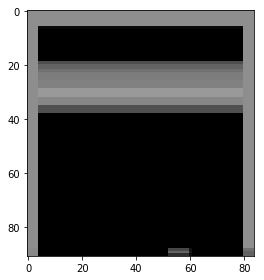

In [61]:
# Create a breakout environment
env = gym.make('BreakoutDeterministic-v4')
# Reset it, returns the starting frame
frame = env.reset()
# Render
# env.render()

# done = False
# while not done:
 
# Perform a random action, returns the new frame, reward and whether the game is over
raw_frame, reward, done, info = env.step(env.action_space.sample())

raw_frame = raw_frame[20:194, 0:160]

# crap image
cropped_frame = raw_frame

rescaled_gray_cropped_frame = preprocess(cropped_frame)

print(rescaled_gray_cropped_frame.shape)

io.imshow(rescaled_gray_cropped_frame)
io.show()

In [40]:
def q_iteration(env, model, state, iteration, memory):
    # Choose epsilon based on the iteration
    epsilon = get_epsilon_for_iteration(iteration)

    # Choose the action 
    if random.random() < epsilon:
        action = env.action_space.sample()
    else:
        action = choose_best_action(model, state)

    # Play one game iteration (note: according to the next paper, you should actually play 4 times here)
    new_frame, reward, is_done, _ = env.step(action)
    memory.add(state, action, new_frame, reward, is_done)

    # Sample and fit
    batch = memory.sample_batch(32)
    fit_batch(model, batch)